# PIV on DE images

Velocimetry analysis is essential in the double emulsion experiment because:

1. it quantifies the bacterial activity (it's interesting to see if activity depends on droplet size)
2. it's an evaluation of the "steady-state" assumption: we can measure mean velocity at the beginning, in the middle and at the end of an experiment and compare the velocities.

Preliminary data shows that bacterial activity (mean velocity) increases with outer droplet size (OD20~40 data). Here, we do a thorough analysis on the whole data set. There are challenges on this analysis:

1. moving droplets: in some videos, the outer droplets move due to coalescence, evaporation and other reasons. Such motion affects PIV results significantly. Here we select the frames where outer droplet motion is negligible for the analysis.
2. change focus: in some videos, we change the focus to see inner droplets better. This leads to big error in PIV. We also review the video first and select appropriate frames for analysis. 
3. Masking: only the motions inside droplets are of interest. Here, we use the "fixed_mask_PIV" method.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from myimagelib.myImageLib import readdata
from myimagelib.pivLib import piv_data, read_piv, compact_PIV
from skimage import io
import os
from IPython.display import clear_output
import matplotlib
import cv2
from scipy.io import loadmat
from nd2reader import ND2Reader

## 1 Set up images and parameters

In [6]:
folder = "/home/zhengyang/drives/Elements/"
date = "01182022"
n = 0
fps = 50
mpp = 0.16
nframe = 10
s = 0

# the following are inferred from above
img_folder = os.path.join(folder, date, "{:02d}".format(n), "raw")
mask_dir = os.path.join(folder, date, "mask", "{:02d}.tif".format(n))
lt = readdata(img_folder, "tif")
l = lt[s:s+nframe]
print("{0:d}/{1:d} frames loaded.".format(len(l), len(lt)))

# create droplet_image instance to call PIV method
di = droplet_image(l, fps, mpp)
di

10/16817 frames loaded.


length: 10, image size: (462, 480), fps: 50.0, mpp: 0.16

### 1.1 A preview tool with a slider
- To check if droplet or focus motion is significant

In [7]:
# load images and create frame number list
img_stack = {}
for num, i in l.iterrows():
    img_stack[int(i.Name)] = io.imread(i.Dir)
frame_numbers = l.Name.astype("int")

plt.ioff()
fig = plt.figure()
plt.ion()
im = plt.imshow(img_stack[frame_numbers.iloc[0]], cmap="gray")
def update(change):
    im.set_data(img_stack[change['new']])
    fig.canvas.draw_idle()
slider = widgets.IntSlider(value=frame_numbers.iloc[0], min=frame_numbers.iloc[0], max=frame_numbers.iloc[-1])
slider.observe(update, names='value')
widgets.VBox([slider, fig.canvas])

### 1.2 Test PIV window size

In [8]:
# make a substack to make test process shorter
small_stack_length = 10
###
di_small = droplet_image(l.iloc[:small_stack_length], fps, mpp) # only take first two frames
di_small

length: 10, image size: (462, 480), fps: 50.0, mpp: 0.16

In [9]:
# compute PIV at various window sizes
piv_winsize = {}
for winsize in range(20, 80, 10):
    overlap = winsize // 2
    mask = io.imread(mask_dir)
    mask2 = cv2.erode(mask, np.ones([winsize, winsize]), iterations=1)
    piv, params = di_small.fixed_mask_piv(winsize, overlap, mask2)
    piv_winsize[winsize] = piv

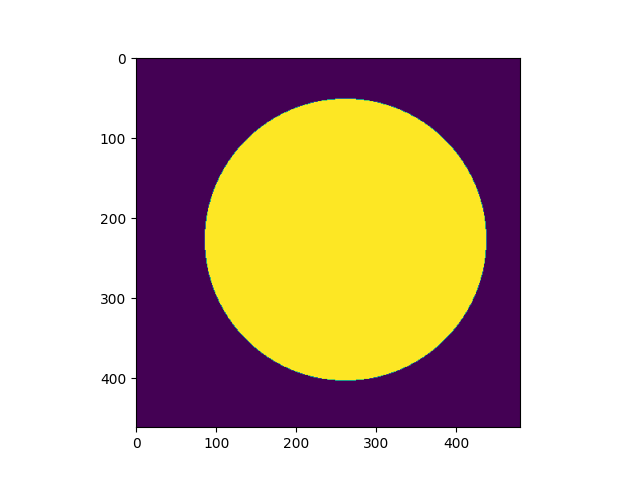

In [10]:
plt.figure()
plt.imshow(mask)

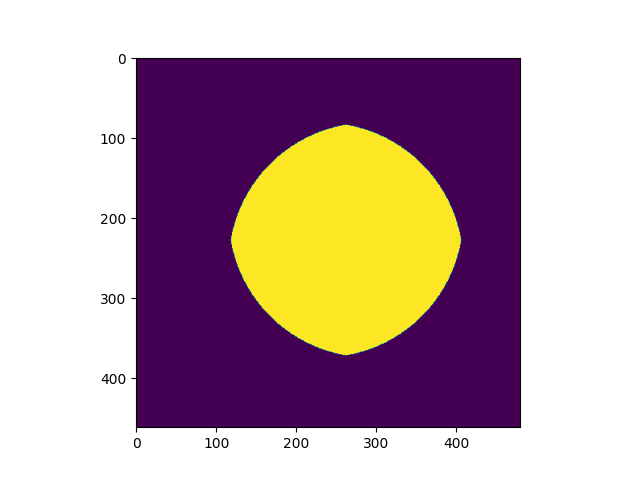

In [11]:
kernel = np.ones((60,60))
mask2 = cv2.erode(mask, kernel, iterations=1)
plt.figure()
plt.imshow(mask2)

#### 1.2.1 Mean velocity vs. window size

We first try different window sizes on the same image set and see if mean velocity depends strongly on the window size. 

In [12]:
def piv_mean_vel(piv):
    """Compute mean vel from dict PIV data."""
    s = 0
    count = 0
    for kw in piv:
        s += np.nanmean(piv[kw].u ** 2 + piv[kw].v ** 2) ** 0.5
        count += 1
    return s  / count

Text(0, 0.5, 'mean velocity (px/s)')

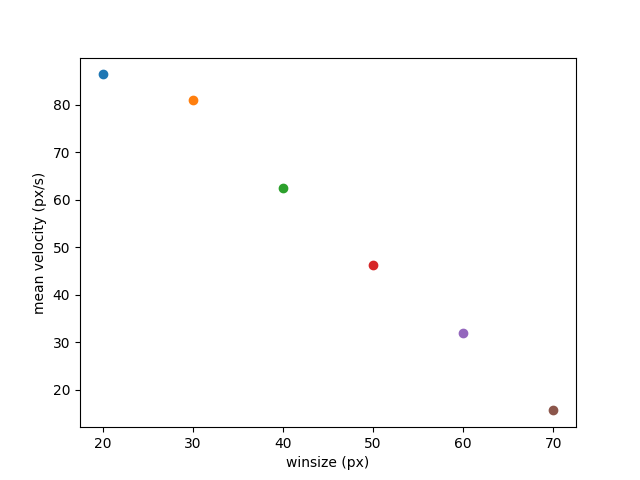

In [13]:
plt.figure()
for winsize in piv_winsize:
    piv = piv_winsize[winsize]
    plt.scatter(winsize, piv_mean_vel(piv))
plt.xlabel("winsize (px)")
plt.ylabel("mean velocity (px/s)")

#### 1.2.2 Visual inspection

Then we overlay the PIV results on images to double check the quality of PIV.

In [33]:
def piv_to_xyuv(pivData):
    """Convert piv dataframe to xyuv matrices."""
    row = len(pivData.y.drop_duplicates())
    col = len(pivData.x.drop_duplicates())
    X = np.array(pivData.x).reshape((row, col))
    Y = np.array(pivData.y).reshape((row, col))
    U = np.array(pivData.u).reshape((row, col))
    V = np.array(pivData.v).reshape((row, col))
    return X, Y, U, V

In [117]:
# visual inspection, check window size effect by slider animation
img = io.imread(di_small.sequence.iloc[0, 1])
winsize = list(piv_winsize.keys())[0]
piv = piv_winsize[winsize]
piv_item = piv[list(piv.keys())[0]]

plt.ioff()
fig = plt.figure(dpi=100)
plt.ion()

plt.imshow(img, cmap="gray")
x, y, u, v = piv_to_xyuv(piv_item)
plt.quiver(x, y, u, v, color="yellow")

def update(change):
    plt.clf()
    plt.imshow(img, cmap="gray")
    winsize = change['new']
    piv = piv_winsize[winsize]
    piv_item = piv[list(piv.keys())[0]]
    x, y, u, v = piv_to_xyuv(piv_item)
    plt.quiver(x, y, u, v, color="yellow")
    fig.canvas.draw_idle()
    
drop = widgets.Dropdown(
            options=piv_winsize.keys(),
            value=list(piv_winsize.keys())[0],
            description='Window size',
            disabled=False)
drop.observe(update, names='value')
widgets.HBox([drop, fig.canvas])

In [118]:
# visual inspection: animation
# choose PIV data
winsize = 20
pivData = piv_winsize[winsize]
keys = list(pivData.keys())


plt.ioff()
fig = plt.figure(dpi=100)
plt.ion()
im = plt.imshow(img_stack[frame_numbers.iloc[0]], cmap="gray")
x, y, u, v = piv_to_xyuv(pivData[keys[0]])
uv = plt.quiver(x, y, u, v, color="yellow")
def update(change):
    frame = change['new']
    im.set_data(img_stack[frame])
    x, y, u, v = piv_to_xyuv(pivData["{0:05d}-{1:05d}".format(frame, frame+1)])
    uv.set_UVC(u, v)
    fig.canvas.draw_idle()
slider = widgets.IntSlider(value=frame_numbers.iloc[0], min=frame_numbers.iloc[0], max=frame_numbers.iloc[-1])
slider.observe(update, names='value')
widgets.HBox([slider, fig.canvas])

## 2 Run PIV at the determined window size

Sample 3 segments from the beginning, the middle and the end of the image sequence. 

In [250]:
winsize = 20
length = 50
start = 500

In [251]:
vm_list = []
for segment in [lt[start: start+length], lt[len(lt)//2:len(lt)//2+length], lt[-length:]]:
    di = droplet_image(segment, fps, mpp) # only take first two frames
    piv, params = di.fixed_mask_piv(winsize, winsize//2, mask_dir)
    vm_list.append(piv_mean_vel(piv)*mpp)
print(vm_list)

[2.8488429524873733, 2.338512001523504, 2.6961715540378615]


## 3 Known issue of PIV

### 3.1 Window size dependence

Too sensitive to the choice of window size. The data below show how mean velocity depends on window size choice for a certain droplet experiment. I have to emphasize that this is a good, large droplet sample. For samples with worse image quality or slower flow, the dependence can be more unpredictable. Therefore, I am seeking a more robust method to quantify the bacterial activity.

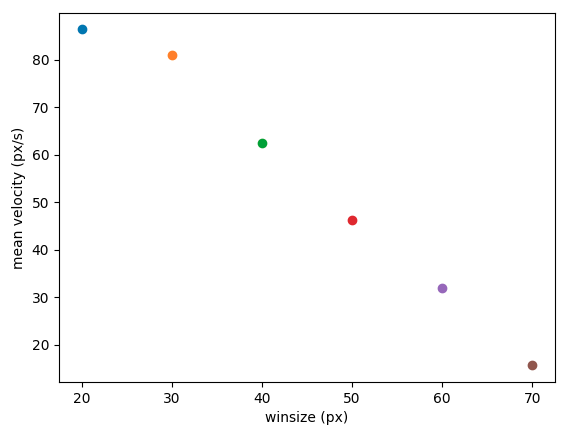

### 3.2 NaN velocities

The batch PIV code generates many velocity fields full of NaN, which is not expected. It might be related to the new version of PIV, which adds a strict sig2noise check. Here, we investigate this issue.

#### 3.2.1 Raw video and PIV data

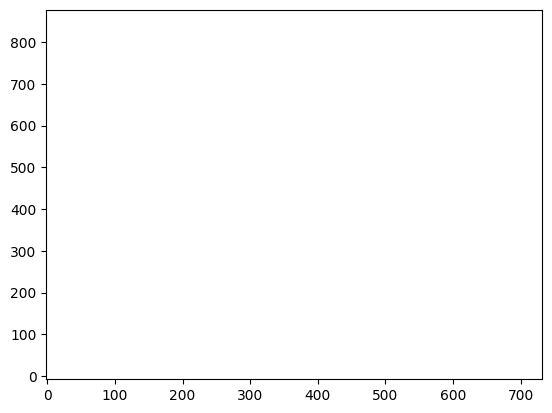

In [27]:
cpiv_dict = loadmat(r"D:\nd2\PIV\024.mat")
cpiv = compact_PIV(cpiv_dict)
x, y, u, v = cpiv.get_frame(10000, by="index")
plt.quiver(x, y, u, v)

We find that video 024 has this issue. So let's do PIV on it step by step to see what is going wrong.

In [28]:
with ND2Reader(r"D:\nd2\024.nd2") as images:
    I0 = images[0]
    I1 = images[1]

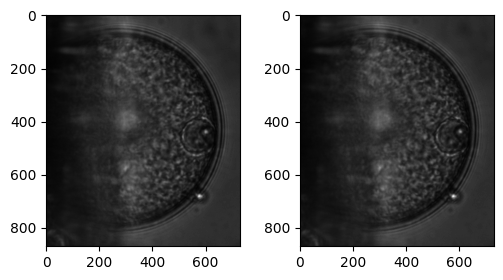

In [31]:
# display the images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
ax[0].imshow(I0, cmap="gray")
ax[1].imshow(I1, cmap="gray")

The images look normal to me. Now let's start the PIV process.

#### 3.2.2 Try function `myimagelib.pivLib.PIV` 

In [66]:
from myimagelib.pivLib import PIV, apply_mask

In [48]:
x, y, u, v = PIV(I0, I1, 32, 16, 0.02)

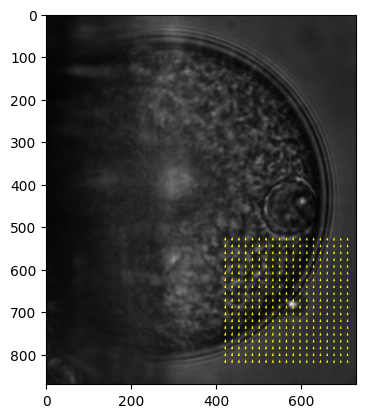

In [49]:
plt.imshow(I0, cmap="gray")
plt.quiver(x, y, u, v, color="yellow")

#### 3.2.3 Decompose PIV function into steps

The PIV function is an integrated process, including normal PIV, validation and outlier replacement. To identify the source of the NaN issue, let's decompose the `PIV` function and test step by step.

In [63]:
from openpiv import pyprocess, validation, filters

In [52]:
u0, v0, sig2noise = pyprocess.extended_search_area_piv(
        I0.astype(np.int32),
        I1.astype(np.int32),
        window_size=32,
        overlap=16,
        dt=0.02,
        search_area_size=32,
        sig2noise_method='peak2peak',
    )

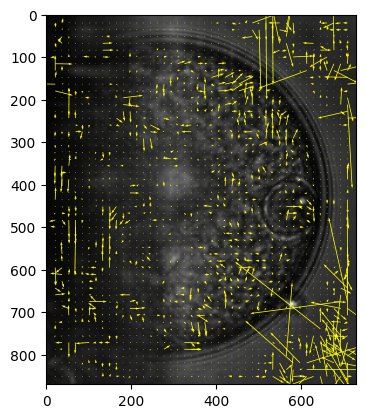

In [53]:
plt.imshow(I0, cmap="gray")
plt.quiver(x, y, u0, v0, color="yellow")

The intial `pyprocess.extended_search_area_piv` gives velocities everywhere. Then `PIV` includes a validation step, which uses the information of signal to noise ratio.

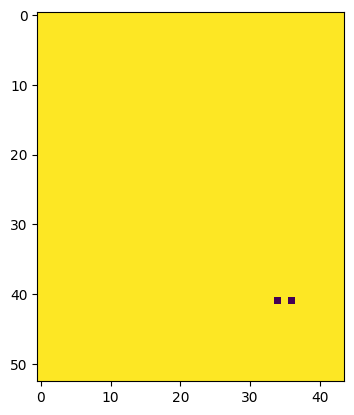

In [61]:
invalid_mask = validation.sig2noise_val(
        sig2noise,
        threshold = 1.05,
    )
plt.imshow(invalid_mask)

We can see, with the critical s2n ratio 1.05, most of the velocities are marked as invalid. If we modify the threshold to 1, we get

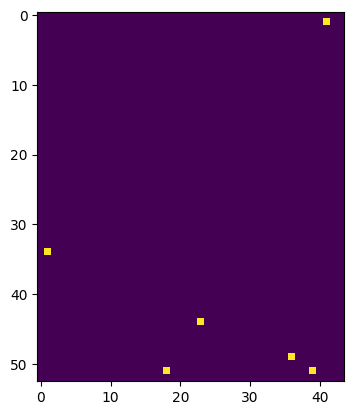

In [62]:
invalid_mask = validation.sig2noise_val(
        sig2noise,
        threshold = 1,
    )
plt.imshow(invalid_mask)

A lot more velocities are valid now.

In [64]:
u2, v2 = filters.replace_outliers(
        u0, v0,
        invalid_mask,
        method='localmean',
        max_iter=3,
        kernel_size=3,
    )

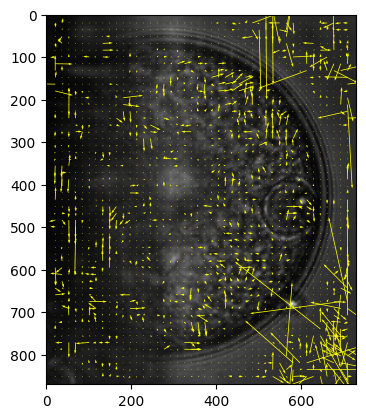

In [65]:
plt.imshow(I0, cmap="gray")
plt.quiver(x, y, u2, v2, color="yellow")

We can try applying the mask for in-droplet region.

In [68]:
mask = io.imread(r"D:\nd2\mask\024.tif")
pivData = pd.DataFrame({"x": x.flatten(), "y": y.flatten(), "u": u2.flatten(), "v": v2.flatten()})
pivData = apply_mask(pivData, mask)

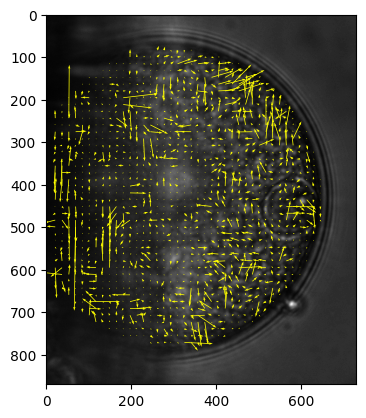

In [71]:
p = pivData.loc[pivData["mask"]==True]
plt.imshow(I0, cmap="gray")
plt.quiver(p.x, p.y, p.u, p.v, color="yellow")

#### 3.2.4 Concluding remarks

The result look OK to me. So in the end, the issue comes from the s2n ratio check, which tends to mark most of the PIV results as invalid. I admit that in some cases the image quality is not great for PIV analysis. But in most cases, the threshold 1.05 seems too strict, since I can observe motions with my naked eye in the images without ambiguity. 

After this investigation, I decide to change the default s2n ratio threshold to 1. This should resolve most of the NaN problems. 

## 4 Check PIV results

In [73]:
with ND2Reader(r"D:\nd2\024.nd2") as images:
    I0 = images[0]
    I1 = images[1]
cpiv_dict = loadmat(r"D:\nd2\PIV\024.mat")
cpiv = compact_PIV(cpiv_dict)
x, y, u, v = cpiv.get_frame(0)

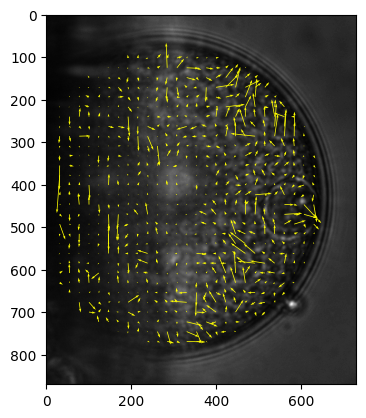

In [75]:
plt.imshow(I0, cmap="gray")
plt.quiver(x, y, u, v, color="yellow")

After changing the s2n ratio threshold, the results are back to normal, without the many NaN's.